In [17]:
# print version / should be 1.6.3
println(versioninfo())

# load centralized paths dictionary
using YAML
PATHS_FILE = "../../../PATHS.yml"
PATHS = YAML.load_file(PATHS_FILE);

"""
    load_path(keys::Vector{String}):String

Return the absolute path for a requested item within the nested PATHS dictionary.
"""
function loadpath(keys::Vector{String}):String
    # recusively assemble paths from keys
    requested_path = foldl((x, y) -> getindex(x, y), keys; init=PATHS)
    # rephrase abs path from relative paths to be platform independent.
    realpath(joinpath(splitdir(realpath(PATHS_FILE))[1], requested_path))
end;

Julia Version 1.6.3
Commit ae8452a9e0 (2021-09-23 17:34 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, broadwell)
Environment:
  __LMOD_REF_COUNT_JULIA_DEPOT_PATH = /home/biotoml/.julia:1;/sw/comp/julia/1.6.3/rackham/lib/glob_pkg:1
  JULIA_DEPOT_PATH = /home/biotoml/lsm/src/.julia/v1.6_depot:/home/biotoml/.julia:/sw/comp/julia/1.6.3/rackham/lib/glob_pkg
  __LMOD_REF_COUNT_JULIA_LOAD_PATH = @:1;@v#.#:1;@stdlib:1;/sw/comp/julia/1.6.3/rackham/lib/glob_pkg/environments/v1.6:1
  JULIA_PROJECT = /home/biotoml/lsm/src/.julia/v1.6_regrid
  JULIA_ROOT = /sw/comp/julia/1.6.3/rackham
  JULIA_LOAD_PATH = @:@v#.#:@stdlib:/sw/comp/julia/1.6.3/rackham/lib/glob_pkg/environments/v1.6
nothing


In [18]:
using IntervalSets
using NaNMath; nm=NaNMath
using NCDatasets
using Revise
using StatsBase

In [19]:
file = "/home/biotoml/lsm/src/.julia/v1.7_depot/artifacts/8e82b3b97603651740df68ff493cb497c6f7b486/CH_20X_1Y_V1.nc"

"/home/biotoml/lsm/src/.julia/v1.7_depot/artifacts/8e82b3b97603651740df68ff493cb497c6f7b486/CH_20X_1Y_V1.nc"

In [20]:
ds = NCDataset(file, "r");

In [21]:
describe(ds["lon"]), describe(ds["lat"])

Summary Stats:
Length:         7200
Missing Count:  0
Mean:           -0.000000
Minimum:        -179.975000
1st Quartile:   -89.987500
Median:         0.000000
3rd Quartile:   89.987500
Maximum:        179.975000
Type:           Float64
Summary Stats:
Length:         3600
Missing Count:  0
Mean:           -0.000000
Minimum:        -89.975000
1st Quartile:   -44.987500
Median:         0.000000
3rd Quartile:   44.987500
Maximum:        89.975000
Type:           Float64


(nothing, nothing)

In [22]:
include("./regridding.jl")

Regridder2D

In [23]:
rgo = Regridder2D(180,360)

Regridder2D{Int64, Float64}(RegridAxis{Int64, Float64}[RegridAxis{Int64, Float64}("lat", -90.0, 90.0, 180), RegridAxis{Int64, Float64}("lon", -180.0, 180.0, 360)])

In [39]:
function init_regridded(ncdims::Tuple; ft::Type{N}=Float64) where N<:Number
    zeros(ft, ncdims)
end

init_regridded (generic function with 2 methods)

In [40]:
function RegridAxis(name::String, pointrange::AbstractArray{FT}) where FT<:AbstractFloat
    prsz½ = stepsize(pointrange) / 2
    prmin = minimum(pointrange) - prsz½
    prmax = maximum(pointrange) + prsz½
    prcard = length(pointrange)
    
    RegridAxis{Int64, FT}(name, prmin, prmax, prcard)
end

function minmaxdist(pointrange::AbstractArray{FT}) where FT<:AbstractFloat
    diff([extrema(pointrange)...])[1] / length(pointrange) * (length(pointrange)+1)
end

stepsize(pointrange::AbstractArray{FT}) where FT<:AbstractFloat = minmaxdist(pointrange)/length(pointrange)


function intsect_intervals(src_itvs::AT, dest_itv::Interval) where {AT<:AbstractArray}
    # first get width and index for intersecting intervals
    map(
        ((j, itv),) -> 
        let isct = dest_itv ∩ itv
                isempty(isct) ? nothing : [j, width(isct)/width(itv)]
        end, 
        enumerate(src_itvs)) |>
    # filter the nothings
    x -> filter(!isnothing, x) |>
    # adjust the type of the array
    x -> isempty(x) ? (return nothing) : convert(Array{eltype(x).b}, x) |>
    x -> reduce(hcat, x)
end

intsect_intervals (generic function with 1 method)

In [41]:
function extract_cell(ncds::NCDataset, itvs::AbstractArray, itvs_ncds::AbstractArray, variables::AbstractArray{String})
    map(var -> extract_subarray(ncds[var], itvs_ncds, itvs), variables)
end

function extract_subarray(data::NCDatasets.CFVariable, dimension_vectors::AbstractArray, dest_itvs::AbstractArray)
    index_wghts = map(((dim_itvs, dest_itv),) -> intsect_intervals(dim_itvs, dest_itv), zip(dimension_vectors, dest_itvs))
    indices = map(j -> convert(Array{Int}, index_wghts[j][1,:]), 1:length(index_wghts))
    wghts = map(j -> index_wghts[j][2,:], 1:length(index_wghts))
    data[indices...], ortho_product(wghts')
end

# simple extension to the 
nm_weighted(data, wghts, operation) = operation(data.*wghts)

function regrid_cell(ncds::NCDataset, itvs::AbstractArray, itvs_ncds::AbstractArray, variables::AbstractArray{String}, operation::Function)
    map(((dt,wt),) -> nm_weighted(dt, wt, operation), extract_cell(ncds, itvs, itvs_ncds, variables))
end

function ortho_multiply(vec1::AT, vec2::AT) where AT <:AbstractArray
    let z=vec1'*vec2
        reshape(z, (1, length(z)))
    end
end

function ortho_product(ortho_bases::AbstractArray)
    flat_tensor = reduce(ortho_multiply, ortho_bases)
    reshape(flat_tensor, (length.(ortho_bases)...))
end

ortho_product (generic function with 1 method)

In [42]:
rgao = RegridAxis("aa", -180., 180., 360)
rgao2 = RegridAxis("exp", ds["lon"][:])

RegridAxis{Int64, Float64}("exp", -179.99999999951774, 179.99999999951777, 7200)

In [43]:
a = intsect_intervals(intervals(rgao2), intervals(rgao)[1])

ivs = map(ax -> intervals(ax)[100], [rgo.axes[2],rgo.axes[1]])

2-element Vector{OpenInterval{Float64}}:
 -81.0..-80.0 (open)
 9.0..10.0 (open)

In [44]:
j = regrid_cell(ds, ivs, ["data", "std"], nm.mean)

LoadError: MethodError: no method matching regrid_cell(::NCDataset{Nothing}, ::Vector{OpenInterval{Float64}}, ::Vector{String}, ::typeof(NaNMath.mean))
[0mClosest candidates are:
[0m  regrid_cell(::NCDataset, ::AbstractArray, ::AbstractArray, [91m::AbstractArray{String, N} where N[39m, [91m::Function[39m) at In[41]:15

---
---

---

In [45]:
function Regridder2D(ncds::NCDatasets.NCDataset; lonname::String="lon", latname::String="lat")
    latcard, loncard= length(ncds[latname]), length(ncds[lonname])
    latmin, latmax = extrema(ncds[latname])
    lonmin, lonmax = extrema(ncds[lonname])

    Regridder2D(latcard, loncard; latmin, latmax, lonmin, lonmax)
end


Regridder2D

In [46]:
Regridder2D(ds)

Regridder2D{Int64, Float64}(RegridAxis{Int64, Float64}[RegridAxis{Int64, Float64}("lat", -89.975, 89.975, 3600), RegridAxis{Int64, Float64}("lon", -179.975, 179.97500000000002, 7200)])

In [47]:
function dimwise_intervals(regridder::RG) where RG<:Regridder
    Dict(x.name => intervals(x) for x in regridder.axes)
end

dimwise_intervals (generic function with 1 method)

In [86]:
function regrid2d_dataset(regridder::Regridder2D, ncds::NCDataset, variables::AbstractArray{String}, operation::Function; kwargs...)
    regridder_ncds = Regridder2D(ncds; kwargs...)
    
    ncdims = keys(ncds.dim)
    dim_itvs = map(x -> dimwise_intervals(regridder)[x], ncdims)
    dim_itvs_ncds = map(x -> dimwise_intervals(regridder_ncds)[x], ncdims)
    
    regridded_ncds = init_regridded(tuple(map(x -> cardinality(regridder)[x], ncdims)...))
    for idx in CartesianIndices(axes(regridded_ncds))
    #for tile in Iterators.product(dim_itvs...)
        idxs = Tuple(idx)
        tile = map(((x,y),) -> x[y], zip(dim_itvs, idxs))
        rgrd_value = regrid_cell(ncds, [tile...], dim_itvs_ncds, variables, operation)
        if rgrd_value[1] > 0
            regridded_ncds[idxs...] = rgrd_value[1]
        end
    end
    
    regridded_ncds
end

regrid2d_dataset (generic function with 1 method)

In [87]:
keys(ds.dim)

2-element Vector{String}:
 "lon"
 "lat"

In [88]:
Regridder2D(ds)

Regridder2D{Int64, Float64}(RegridAxis{Int64, Float64}[RegridAxis{Int64, Float64}("lat", -89.975, 89.975, 3600), RegridAxis{Int64, Float64}("lon", -179.975, 179.97500000000002, 7200)])

In [89]:
d=regrid2d_dataset(rgo, ds, ["data"], nm.mean)

360×180 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [91]:
using Plots

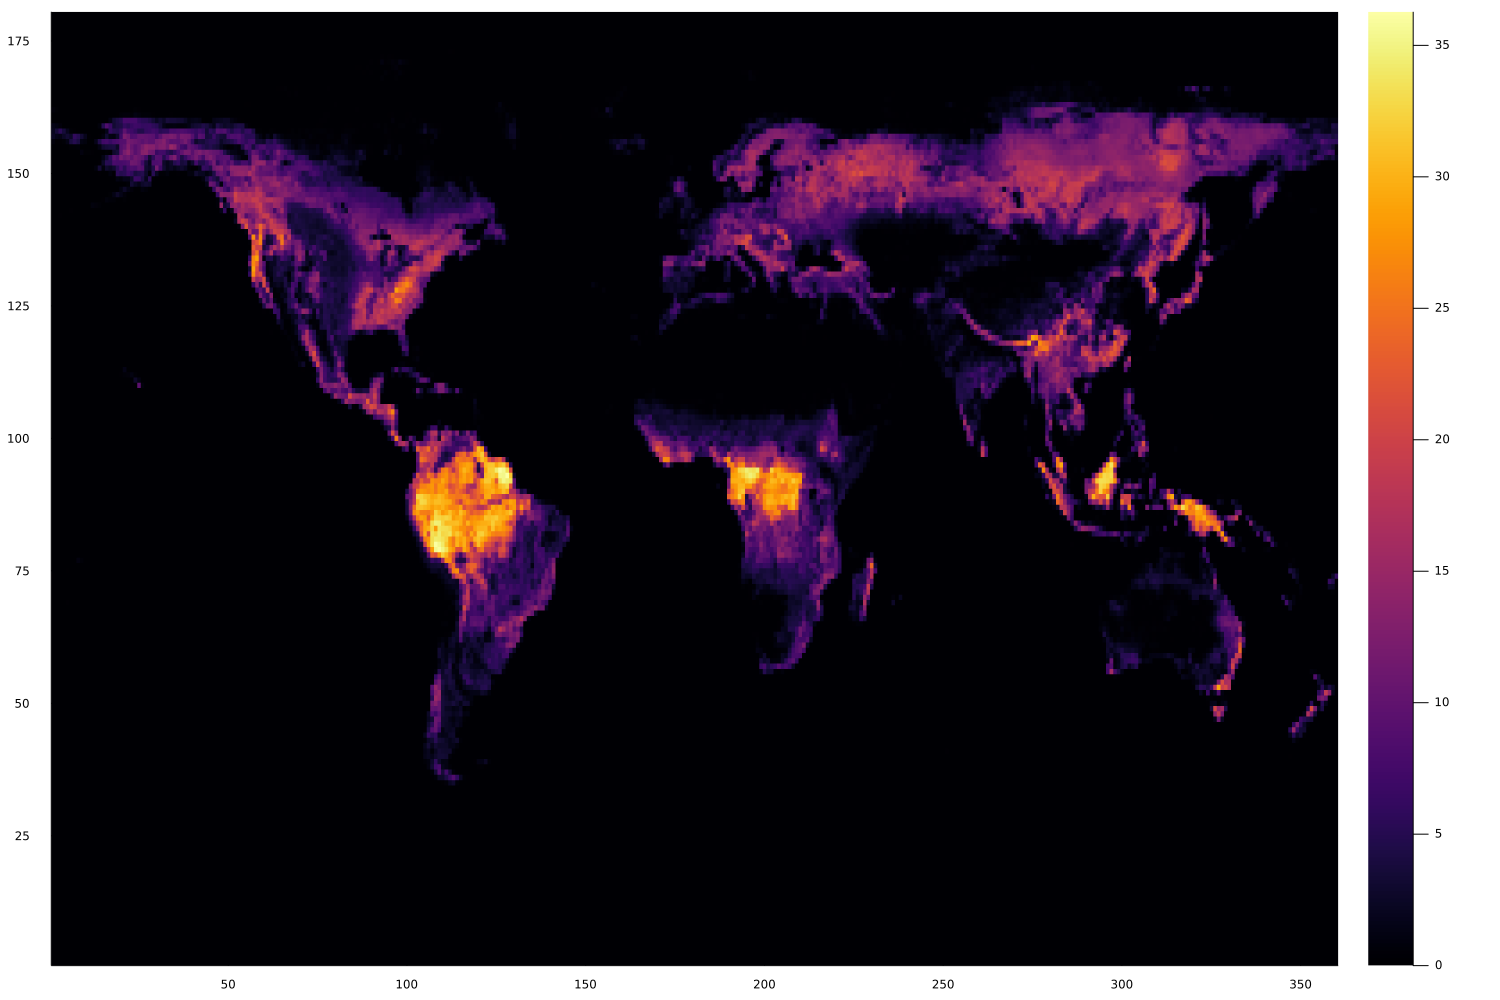

In [94]:
heatmap(d', size=(1500,1000))

In [37]:
for j in axes(init_regridded(rgo))
    print(j)
end

LoadError: MethodError: no method matching init_regridded(::Regridder2D{Int64, Float64})
[0mClosest candidates are:
[0m  init_regridded([91m::AbstractArray[39m; ft) at In[24]:1

In [79]:
CartesianIndices(axes(init_regridded(rgo)))

180×360 CartesianIndices{2, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}:
 CartesianIndex(1, 1)    CartesianIndex(1, 2)    …  CartesianIndex(1, 360)
 CartesianIndex(2, 1)    CartesianIndex(2, 2)       CartesianIndex(2, 360)
 CartesianIndex(3, 1)    CartesianIndex(3, 2)       CartesianIndex(3, 360)
 CartesianIndex(4, 1)    CartesianIndex(4, 2)       CartesianIndex(4, 360)
 CartesianIndex(5, 1)    CartesianIndex(5, 2)       CartesianIndex(5, 360)
 CartesianIndex(6, 1)    CartesianIndex(6, 2)    …  CartesianIndex(6, 360)
 CartesianIndex(7, 1)    CartesianIndex(7, 2)       CartesianIndex(7, 360)
 CartesianIndex(8, 1)    CartesianIndex(8, 2)       CartesianIndex(8, 360)
 CartesianIndex(9, 1)    CartesianIndex(9, 2)       CartesianIndex(9, 360)
 CartesianIndex(10, 1)   CartesianIndex(10, 2)      CartesianIndex(10, 360)
 CartesianIndex(11, 1)   CartesianIndex(11, 2)   …  CartesianIndex(11, 360)
 CartesianIndex(12, 1)   CartesianIndex(12, 2)      CartesianIndex(12, 360)
 CartesianIndex(13, 1) 

In [80]:
init_regridded(rgo)

180×360 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0